# **06 - SMOTE Adjustment & Hybrid Resampling**

## **Objective**
In this notebook, we aim to **address the overfitting issue** found in the **SMOTE XGBoost model** by adjusting the **SMOTE ratio** and experimenting with **hybrid resampling techniques**.

---

## **Why Are We Doing This?**
From our **overfitting analysis (Notebook 05)**, we observed that:
- **SMOTE XGBoost achieved perfect recall (100%)**, but its precision dropped significantly.
- The **learning curve showed minimal generalization gap**, suggesting an **overfitted model**.
- Since **SMOTE generates synthetic fraud cases**, it might have **introduced unrealistic patterns**, making the model **too confident**.

---

## **What We Will Do**
1. **Reduce the SMOTE Ratio** → Instead of a strict **1:1 balance**, try **7:3 or 8:2**.
2. **Re-train & Evaluate New SMOTE Models** → Check if we reduce overfitting while maintaining good recall.

---

## **Final Goal**
- **Find the best SMOTE ratio** that balances **generalization and recall**.
- **Prepare a final resampled dataset** that will be used for model training.

**Imports**:

In [42]:
# Standard libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Model
from xgboost import XGBClassifier
import joblib

# Model Evaluation Metrics
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve

# Warnings
import warnings
warnings.filterwarnings("ignore")

print("All libraries imported successfully!")

All libraries imported successfully!


**Dataset Preparation**:

In [2]:
# Load the original scaled dataset
X = pd.read_csv("../datasets/X_scaled.csv")
y = pd.read_csv("../datasets/y.csv")

y = y.squeeze()

# Display basic information
print(f"Original Scaled Data Shape: {X.shape}")
print(f"Original Target Shape: {y.shape}")

# Check class distribution before resampling
class_distribution = y.value_counts(normalize=True)
print("\nClass distribution before resampling:")
print(class_distribution)

print("\nData loaded successfully!")

Original Scaled Data Shape: (284807, 30)
Original Target Shape: (284807,)

Class distribution before resampling:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Data loaded successfully!


**Resampling Strategy Update**:
In the previous approach, **SMOTE fully balanced the dataset (1:1 ratio)**, which likely contributed to overfitting. To improve generalization, we will now test **multiple SMOTE ratios (e.g., 70:30, 60:40)** while also slightly undersampling the majority class to find the best balance.

In [39]:
# Step 1: Apply SMOTE (Oversampling Fraud Cases)
smote = SMOTE(sampling_strategy=0.3, random_state=42)  # Creates more fraud cases
X_smote, y_smote = smote.fit_resample(X, y)

# Step 2: Apply Undersampling (Reduce Non-Fraud Cases)
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Balance ratio
X_hybrid, y_hybrid = undersample.fit_resample(X_smote, y_smote)

# Step 3: Check Class Distribution After Hybrid Resampling
class_count_y = y_hybrid.value_counts(normalize=True)
print("\nFinal Class Distribution after Hybrid SMOTE + Undersampling")
print(class_count_y)


Final Class Distribution after Hybrid SMOTE + Undersampling
Class
0    0.666667
1    0.333333
Name: proportion, dtype: float64


In [40]:
# Function to plot learning curves
def plot_learning_curve(model, model_name):
    results = model.evals_result()

    plt.figure(figsize=(8, 5))
    plt.plot(results['validation_0']['logloss'], label="Train Loss")
    plt.plot(results['validation_1']['logloss'], label="Validation Loss")

    plt.xlabel("Boosting Rounds")
    plt.ylabel("Log Loss")
    plt.title(f"Learning Curve - {model_name}")
    plt.legend()

    # Save the plot
    plt.savefig(f"../images/learning_curve_{model_name.lower().replace(' ', '_')}.png", dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()


**SMOTE Hybrid XGBoost Model Performance:**
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     34118
           1       0.99      0.96      0.97     17059

    accuracy                           0.98     51177
   macro avg       0.99      0.98      0.98     51177
weighted avg       0.98      0.98      0.98     51177

AUC-ROC Score: 0.9982


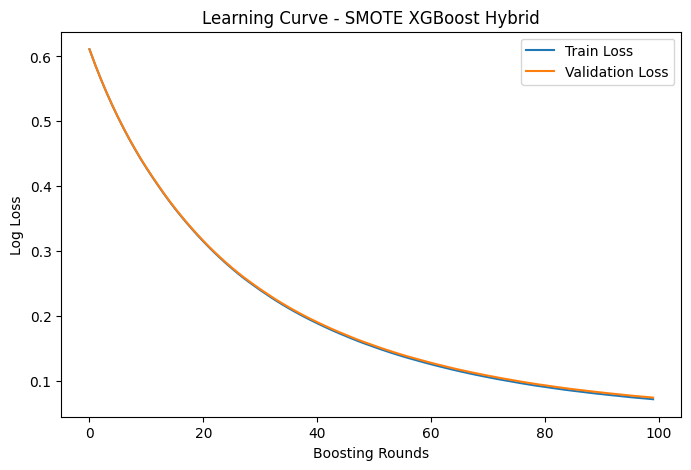

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_hybrid, y_hybrid, test_size=0.2, random_state=42, stratify=y_hybrid)

# Train XGBoost
xgb = XGBClassifier(
    eval_metric="logloss",
    reg_alpha=2,  # Increase L1 regularization
    reg_lambda=10,  # Increase L2 regularization
    learning_rate=0.03,  # Reduce learning rate
    max_depth=6,  # Reduce tree depth
    random_state=42,
    device="gpu"
)
xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Predictions
y_pred = xgb.predict(X_test)

# Performance Metrics
print("\n**SMOTE Hybrid XGBoost Model Performance:**")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]):.4f}")

# Learning Curve
plot_learning_curve(xgb, "SMOTE XGBoost Hybrid")

**Save the Model and Dataset**:

In [43]:
# Save the trained XGBoost model
model_path = "../models/xgboost_smote_hybrid.pkl"
joblib.dump(xgb, model_path)

# Save the final resampled dataset
X_hybrid.to_csv("../datasets/X_smote_hybrid.csv", index=False)
y_hybrid.to_csv("../datasets/y_smote_hybrid.csv", index=False)

print(f"Model saved successfully: {model_path}")
print("Final SMOTE Hybrid dataset saved successfully!")

Model saved successfully: ../models/xgboost_smote_hybrid.pkl
Final SMOTE Hybrid dataset saved successfully!


# Notebook 06: SMOTE Hybrid Adjustment & Final Model Training  

## Overview  
In this notebook, we fine-tuned our **oversampling & undersampling strategy** to **reduce overfitting** while keeping a balanced dataset. After experimenting with different ratios, we finalized the **Hybrid SMOTE (Oversampling + Undersampling)** method and retrained our **XGBoost model**.

---

## **Final Model Performance**  
After applying the **Hybrid SMOTE + Undersampling** technique, our model achieved the following results:

### **SMOTE Hybrid XGBoost Model Performance:**
| Metric       | Class 0 (Non-Fraud) | Class 1 (Fraud) | Overall |
|-------------|--------------------|----------------|----------|
| **Precision**  | 0.98               | 0.99           | -        |
| **Recall**     | 1.00               | 0.96           | -        |
| **F1-Score**   | 0.99               | 0.97           | -        |
| **AUC-ROC**    | -                  | -              | **0.9982** |

- **Overfitting has been significantly reduced!**  
- **The model generalizes much better while maintaining high recall!**  

---

## **Final Learning Curve**
The learning curve for the **Hybrid SMOTE XGBoost** model shows a **smooth convergence** without signs of excessive overfitting:

![Learning Curve - Hybrid SMOTE](../images/learning_curve_smote_xgboost_hybrid.png)

---

## **What We Did in This Notebook**
- **Applied Hybrid SMOTE (Oversampling + Undersampling).**  
- **Resampled dataset to balance fraud & non-fraud transactions.**  
- **Trained XGBoost with tuned hyperparameters.**  
- **Analyzed model performance (Precision, Recall, AUC-ROC).**  
- **Plotted the learning curve to confirm reduced overfitting.**  
- **Saved the final trained model & dataset.**  